In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams.update({'font.size': 12})

# Filtering

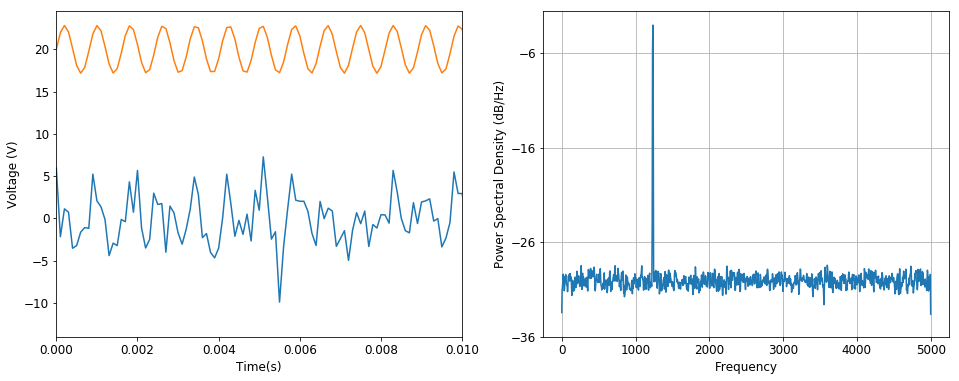

In [180]:
# Start with a noisy sine wave

fs = 10e3 # sampling frequency
N = 1e5 # number of samples
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
t = np.arange(N) / fs
xs = amp*np.sin(2*np.pi*freq*time) # The original sine wave
x = xs + np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

plt.subplot(121)
plt.plot(t,x)
plt.plot(t,xs+20)
plt.xlabel("Time(s)")
plt.xlim((0,0.01))
plt.ylabel("Voltage (V)")
plt.subplot(122)
plt.psd(x,Fs=fs, NFFT=2**11);

Note that you really can't see the original 1234 Hz sine wave (orange) because of the noise. But if you look at the power spectral density, there is clearly a peak, so it must be there. Here, we will explore use filtering to make this sine wave visible in a plot of voltage vs time.

## Basic concepts of filtering

A common way to remove noise from your data is to apply a low-pass filter: 

https://en.wikipedia.org/wiki/Low-pass_filter

This is equivalent to passing your electrical signal through the following <a href=https://en.wikipedia.org/wiki/RC_circuit>RC circuit</a>:

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/1st_Order_Lowpass_Filter_RC.svg/320px-1st_Order_Lowpass_Filter_RC.svg.png>

To predict what the output voltage is for a given input voltage, we need to know the <a href=https://en.wikipedia.org/wiki/Infinite_impulse_response>infinite impulse response</a>, which is the response of the circuit to an input an input voltage that is a delta-function $\delta(0)$. For the circuit above, the impulse response is given by (see <a href=https://en.wikipedia.org/wiki/RC_circuit#Impulse_response>here</a>):

\begin{equation*}
h(t) = \frac{1}{\tau} e^{-\frac{-t}{\tau}} \theta(t)
\end{equation*}

where $\tau = RC$ is the RC time constant of the circuit, and $\theta(t)$ is a step function.

We can see what this looks like:

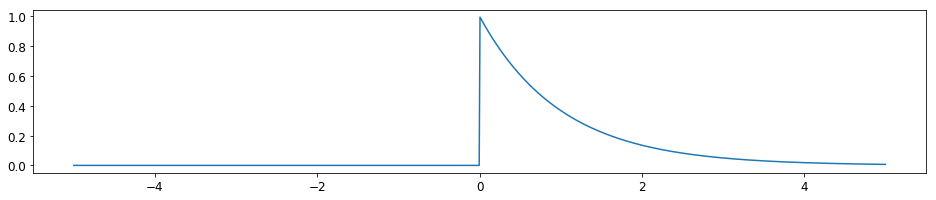

In [104]:
tau = 1
plt.figure(figsize=(16,3))
t = np.linspace(-5,5,1000)
h = np.exp(-t)*(t>=0)
plt.plot(t,h)

 For any given input voltage $V_in(t)$, the output voltage is then given by:

\begin{equation}
V_{out}(t) = \int_{-\infty}^t V_{in}(t-\tau) h(\tau) d\tau
\end{equation}

A nice way to understand what this does is to make a plot. The output voltage $V_{out}$ at time $t_0$ is a "weighted average" of all the input voltages $V_{in}$ at times $t < t_0$ where the "weighing factor" is given by the function $h(-\tau)$ that is decaying exponentially "backwards" in time:

Text(0.5, 0, 'Time')

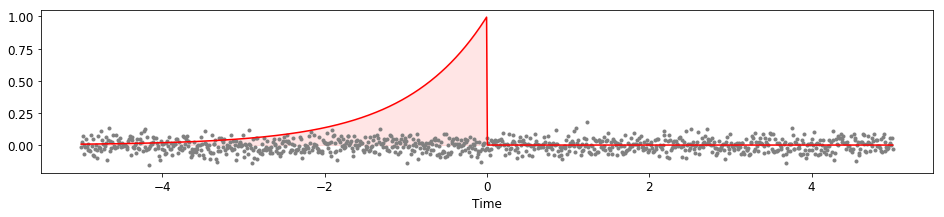

In [69]:
plt.figure(figsize=(16,3))
vin = np.random.normal(size=len(t))*0.05
plt.plot(t,vin,'.', color='grey')
plt.plot(t,np.exp(t)*(t<0),'r')
plt.fill_between(t,np.exp(t)*(t<0), alpha=0.1, color='r')
plt.xlabel("Time")

We say that this filter has a "memory" because the value of $V_{out}$ depends on the values of $V_{in}$ in the past. We also say that it is "causal" because the value of $V_{out}$ at time $t$ does not depend on values of $V_{in} in the future.

(Any real fiter you make in the lab will of course be "causal", but in softare you can easily make a non-causal filter if you want...)

## Filtering in the frequency domain

While it is possible to apply a low pass filter by convolving $V_{in}(t)$ with $h(\tau)$ using, for example, two nested `for` loops, it is far more common in practice to perform filtering in the frequency domain.

(The reason for this is partially that filtering in the frequency domain also has a nice intuitive picture, but also because the Fast Fourier Transform (FFT) makes it far more comptuationally efficient to filter in the frequency domain. In fact, for this reason, it is quite common to calculate all convolution integrals using Fourier tranforms in coputations!)

To see how this works, we first look at an imporant mathematical result, known as the <a href=https://en.wikipedia.org/wiki/Convolution_theorem>convolution theorem</a>. Consider now a completely general function $c(x)$ given by the convolution of two function $f(x)$ and $g(x)$: 

\begin{equation}
c(x) = \int_{-\infty}^{\infty} f(y) g(x-y) dy
\end{equation}

If $\tilde f(\omega)$ and $\tilde g(\omega)$ are the Fourier transforms of $f(x)$ and $g(x)$ respectively, then the convolution theorem states that the Fourier transform $\tilde c(\omega)$ of $c(x)$ is given by: 

\begin{equation}
\tilde c(\omega) = \tilde f(\omega) \ \tilde g(\omega)
\end{equation}

This is a big deal! Why? In the first equation above, for each point in $h(x)$ I need to calculate a full integral. If these are all vectors of size $N$, this integral takes $N$ steps, and so calculating $h(x)$ take order $N^2$ steps. In the second equation, this is only **point-wise multiplication** of the two functions! So if I work in Fourier space, calculating the Fourier transform $\tilde c(\omega)$ takes only order $N$ steps. If $N$ is $10^6$, this is the differenc between $10^6$ steps and $10^{12}$ steps, **which is a big difference!** If a step takes 1 ms, this is the difference between a calculation of 3.6 hours or 31 years!

(Of course, we still need to take the Fourier transform and inverse Fourier transform, but thanks to Gauss' genius, this scales only like $N\log N$, so only $6\times10^6$ steps.)

To calculate $V_{out}$ of our filter, we then need to find the Fourier transform of our impulse response function $h(t)$. For the low pass filter above, this is given by:

\begin{equation}
\tilde h(\omega) = \frac{1}{1+i\omega \tau}
\end{equation}

The Fourier transform $\tilde h(\omega)$ of the impulse response function is also referred to as the <a href=https://en.wikipedia.org/wiki/Transfer_function>Transfer Function</a>. In our case, it tells you how the amplitude and phase of an oscillating input signal is realted to the amplitude and phase of the output signal. Using <a href=https://en.wikipedia.org/wiki/Phasor>phasor notation</a> $V(t) = \tilde V e^{-i\omega t}$, the input and output signals are related by:

\begin{equation}
\tilde V_{out}(\omega) = \tilde h(\omega) \tilde V_{in}(\omega)
\end{equation}

You can see a plot of the transfer function for an RC filter here: 

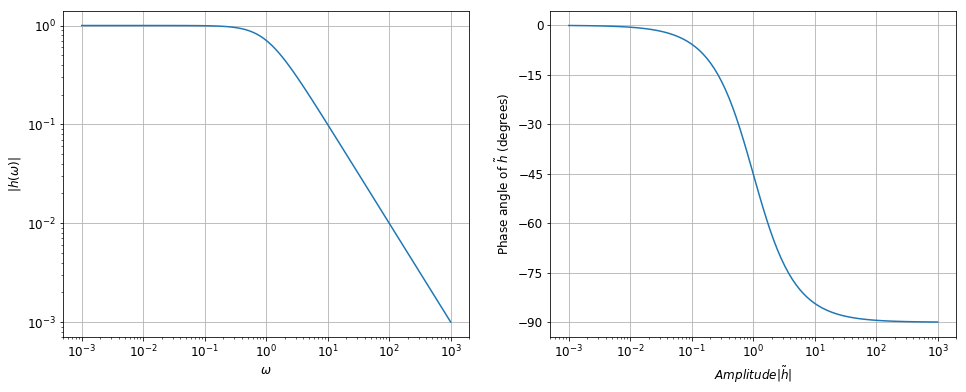

In [100]:
tau = 1
w = np.geomspace(1e-3,1e3, 100)
h = 1/(1+1j*w*tau)

plt.subplot(121)
plt.plot(w,np.abs(h))
plt.xlabel("$\omega$")
plt.ylabel("$|h(\omega)|$")
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.subplot(122)
plt.plot(w, np.angle(h)/np.pi*180)
plt.xscale('log')
plt.xlabel(r"$Amplitude |\tilde h|$")
plt.ylabel(r"Phase angle of $\tilde h$ (degrees)")
plt.grid()
plt.yticks(np.arange(-90,1,15));


We are now ready to try filtering our data! To do this, we will first transform our noisy sine wave signal, then apply a low-pss filter with an appropriate $\tau$, then perform the inverse Fourier transform.

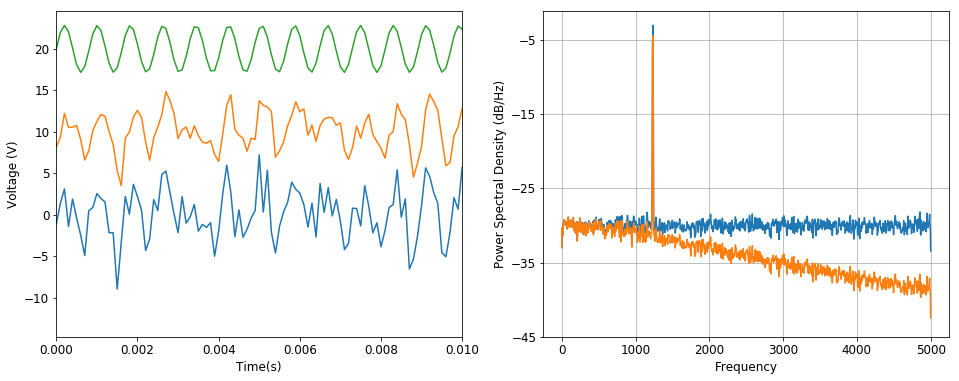

In [229]:
fs = 10e3 # sampling frequency
N = 1e5 # number of samples
T = N/fs # total time trace length
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
t = np.arange(0,T,1/fs)
xs = amp*np.sin(2*np.pi*freq*t)
x = xs + np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

# FFT our data
xf = np.fft.fft(x)
f = np.fft.fftfreq(len(x), t[1])

# Now define the filter
fc = 2e3; # cutoff frequency (note f NOT \omega!)
tau = 1/2/np.pi/fc
h = 1/(1+1j*2*np.pi*f*tau)

# Now multiply the two and take the inverse fourier transform
xf_filt = xf*h
x_filt = np.fft.ifft(xf_filt)
x_filt = np.real(x_filt)

#plt.figure(figsize=(16,10))
tmax = 0.01

plt.subplot(121)
plt.plot(t,x)
plt.plot(t,x_filt+10) # offset them for clarity
plt.plot(t,xs+20)

plt.xlabel("Time(s)")
plt.xlim((0,tmax))
plt.ylabel("Voltage (V)")
plt.subplot(122)
plt.psd(x,Fs=fs, NFFT=2**11);
plt.psd(x_filt,Fs=fs, NFFT=2**11);

By filtering the data, the noise is reduced! But still, it is hard to see the original sine wave. However, as we can see in the power spectral density, the problem is that our filter is not very "sharp". 

One way we can improve this is by filtering twice. The RC filter is known as a "single pole" filter (there is one <a href="https://en.wikipedia.org/wiki/Pole%E2%80%93zero_plot">pole</a> in the complex plane of the transfer function). We can make our filter better by applying it twice (a two-pole filter), or $n$ times (an n-pole filter):

\begin{equation}
\tilde V_{out}(\omega) = [\tilde h(\omega)]^n \ \tilde V_{in}(\omega)
\end{equation}

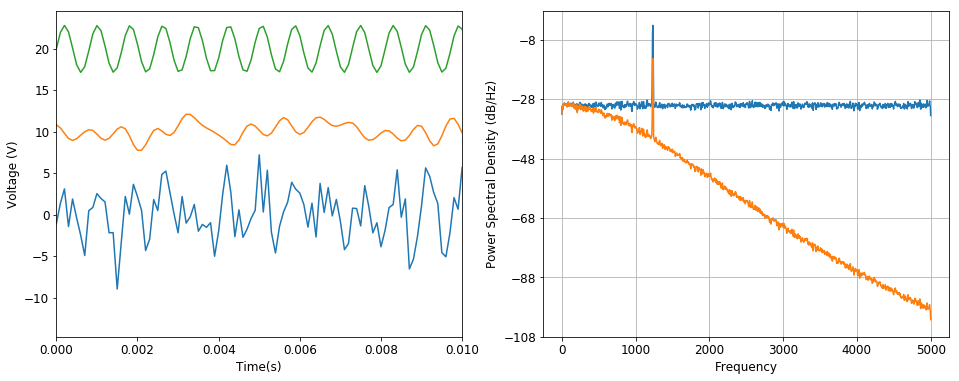

In [231]:
# Now define the filter
fc = 2e3; # cutoff frequency (note f NOT \omega!)
tau = 1/2/np.pi/fc # the filter time constant
h = 1/(1+1j*2*np.pi*f*tau)

# A multi-pole filter
n = 8 # order of the filter
xf_filt = xf*h**n 
x_filt = np.fft.ifft(xf_filt)
x_filt = np.real(x_filt)

#plt.figure(figsize=(16,10))
tmax = 0.01

plt.subplot(121)
plt.plot(t,x)
plt.plot(t,x_filt+10)
plt.plot(t,xs+20)

plt.xlabel("Time(s)")
plt.xlim((0,tmax))
plt.ylabel("Voltage (V)")
plt.subplot(122)
plt.psd(x,Fs=fs, NFFT=2**11);
plt.psd(x_filt,Fs=fs, NFFT=2**11);

If you look, you can now start to see the oscillations of the original sine wave in the filtered data: in particular, we've gotten rid of much of the high-freqeuency noise, as you can see in the power spectral density plot. (Remember: dB is a log scale! at teh highest frequency, we've supressed the noise by something like 70 dB, which is a factor of $10^7$ in power!).

If we know what frequency to look at, we can also use a notch filter. One example of a notch filter is the response of a damped RLC circuit (ie. the response of a damped harmonic oscillator), which for low enough damping coefficients gives a Lorentzian transfer function:

\begin{equation}
\tilde h(\omega) = \frac{1}{1 + i(\omega-\omega_0)/\kappa}
\end{equation}

This function has a sharp peak at $\omega = \omega_0$, and with full width at half maximum (FWHM) of $|\tilde h(\omega)|^2$ (power bandwidth) of $\kappa$:

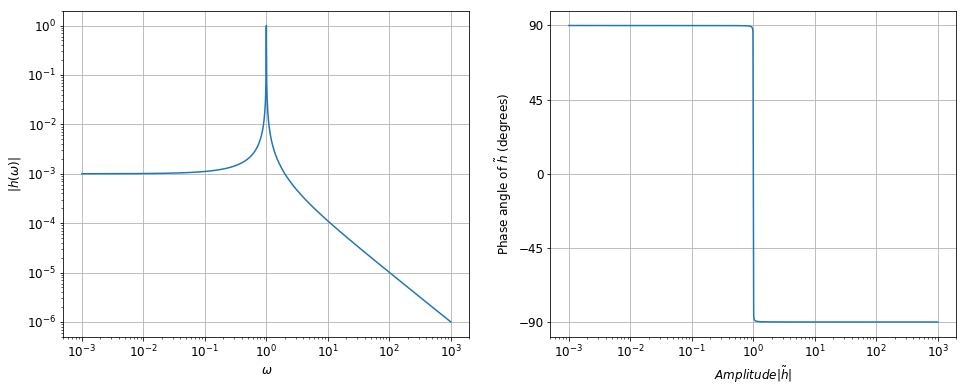

In [221]:
tau = 1
w = np.geomspace(1e-3,1e3, 1001)
w0 = 1
kappa = 0.001
h = 1/(1+1j*(w-w0)/kappa)

plt.subplot(121)
plt.plot(w,np.abs(h))
plt.xlabel("$\omega$")
plt.ylabel("$|h(\omega)|$")
plt.xscale('log')
plt.yscale('log')
plt.ylim((5e-7,2e0))
plt.grid()

plt.subplot(122)
plt.plot(w, np.angle(h)/np.pi*180)
plt.xscale('log')
plt.xlabel(r"$Amplitude |\tilde h|$")
plt.ylabel(r"Phase angle of $\tilde h$ (degrees)")
plt.grid()
plt.yticks(np.arange(-90,91,45));

(It also has a phase shift that now changes by $2 \pi$ at $\omega = \omega_0$.) This filter function is much more peaked, so if we pick it at the correct frequency, it will be very effective at removing our noise without affecting the signal we are interested in:

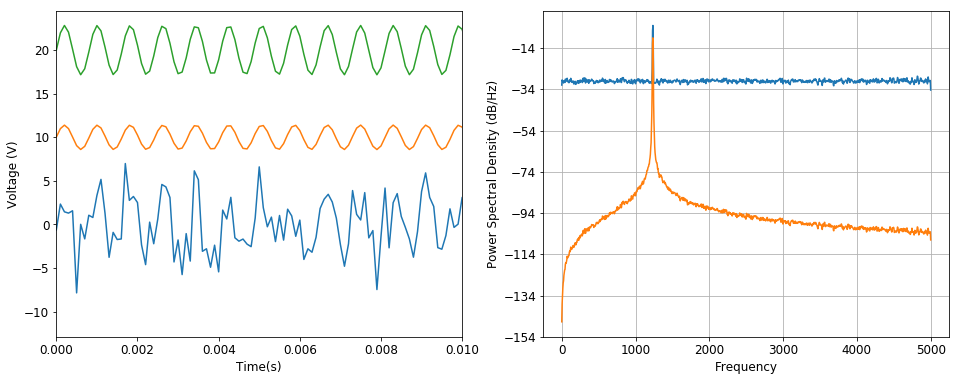

In [211]:
fs = 10e3 # sampling frequency
N = 1e5 # number of samples
T = N/fs # total time trace length
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
t = np.arange(0,T,1/fs)
xs = amp*np.sin(2*np.pi*freq*t)
x = xs + np.random.normal(scale=np.sqrt(noise_power), size=t.shape)

# FFT our data
xf = np.fft.fft(x)
f = np.fft.fftfreq(len(x), t[1])

# Define the filter
# We will work in f rather than \omega. If we specify everything
# in Hz rather than rad/s, then the 2*pi all cancel out

f0 = 1234 # The frequency of 1234 Hz that we want to keep
kappa = 1 # A filter bandwidth of 10 Hz 
h = 1/(1+1j*(f-f0)/kappa)

xf_filt = xf*h 
x_filt = np.fft.ifft(xf_filt)
x_filt = np.real(x_filt)

#plt.figure(figsize=(16,10))
tmax = 0.01

plt.subplot(121)
plt.plot(t,x)
plt.plot(t,x_filt+10)
plt.plot(t,xs+20)

plt.xlabel("Time(s)")
plt.xlim((0,tmax))
plt.ylabel("Voltage (V)")
plt.subplot(122)
plt.psd(x,Fs=fs, NFFT=2**11);
plt.psd(x_filt,Fs=fs, NFFT=2**11);

With this filter, you can now really see the original sine wave oscillation back in the data! 

The reason is that our filter has suppressed the noise at all frequencies except for the one we are interested in as you can see in the power spectral density.

This, by the way, is how <a href="https://en.wikipedia.org/wiki/Lock-in_amplifier">lock-in amplifiers</a> work to extract tiny repeating signals from very noisy measurments.

Ideally, the green and orange curves should be the same amplitude. I suspsect this is an effect from the finite frequency spacing of our Fourier transform. With narrow filters, if the quantisation of your frequency steps doesn't coincide with your chosen $\omega_0$, then the peak of the discretised transfer function will not be unity. You can see this above in the plots of the notch filter transfer function above: try changing the definition of `w` to `w = np.geomspace(1e-3,1e3, 1000)`. 

If you are performing quantitative analysis of data like this, you should make sure to have very long datasets so that the frequency spacing $\delta f = 2/T$ is very small compared to $\kappa$ to avoid any artifacts from discretisation. 

In addition to this "brute force" approach, you can also be very careful to arrange your data acquisition such that the frequency point `f0` exactly corresponds to one of the discrete frequency entries in your frequency array `f = np.fft.fftfreq(len(x), t[1])`. (Technically, this requires your sampling rate, and total sampling time, to be commensurate with $\omega_0$.)